In [1]:
import tensorflow as tf
import os
from tqdm import tqdm
from model_simple_encoding import *

2023-06-05 18:48:23.272961: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-05 18:48:23.313213: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
tf.config.list_physical_devices('GPU')

2023-06-05 18:48:24.101335: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-05 18:48:24.117903: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-05 18:48:24.118044: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    print("Could not set memory growth")
    # Invalid device or cannot modify virtual devices once initialized.
    pass

In [4]:
import pickle
with open("str_to_int", "rb") as f:
    str_to_int = pickle.load(f)

with open("int_to_str", "rb") as f:
    int_to_str = pickle.load(f)
    
encode = lambda s: [str_to_int[c] for c in s]
decode = lambda l: ''.join([int_to_str[i] for i in l])

In [5]:
model = Multinomial_Model()

2023-06-05 18:48:24.839298: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-05 18:48:24.841249: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-05 18:48:24.841462: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-05 18:48:24.841534: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node,

In [6]:
# params:
learning_rate = 1e-3

In [7]:
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

In [8]:
val_data = tf.data.Dataset.load(f"./shards/val_shard_simple")
loss_epoch = []
val_loss_epoch = []

In [9]:
epochs = 100
for epoch in range(epochs):
    print(f"\nStart of epoch {epoch+1}:")
    loss_total = 0
    count_train = 0
    for file in os.listdir("./shards"):
        if file.startswith("shard_simple"):
            print(f"working on {file}...")
            curr_train = tf.data.Dataset.load(f"./shards/{file}")
            with tqdm(total=len(curr_train)) as pbar:
                for x, y in curr_train: # Of size (batch, embd)
                    with tf.GradientTape() as tape:
                        logits, loss = model(x = x, y = y, training=True)
                    loss_total += loss
                    count_train += 1
                    grads = tape.gradient(loss, model.trainable_weights)
                    optimizer.apply_gradients(zip(grads, model.trainable_weights))
                    pbar.update(1)
    #### Validation:
    val_loss_total = 0
    count_val = 0
    for x_val, y_val in val_data:
        _, val_loss = model(x = x_val, y = y_val, training=False)
        val_loss_total += val_loss
        count_val += 1
    avg_train_loss = loss_total/count_train
    avg_val_loss = val_loss_total / count_val
    loss_epoch.append(avg_train_loss)
    val_loss_epoch.append(avg_val_loss)
    print(f"Average Training loss: {avg_train_loss}")
    print(f"Average Validation loss : {avg_val_loss}")
    print("------------------------------------\n")
    
    if epoch+1 > 40 and (epoch+1) % 5 == 0:
        print(f"Saving model at epoch {epoch+1}")
        model.save_weights(f"./checkpoints/my_checkpoint_simple_encoding_epoch{epoch+1}")


Start of epoch 1:
working on shard_simple_2...


  0%|                                                            | 0/1742 [00:00<?, ?it/s]2023-06-05 18:48:47.010802: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2023-06-05 18:48:47.048549: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
100%|█████████████████████████████████████████████████| 1742/1742 [03:18<00:00,  8.76it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:18<00:00,  8.76it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:18<00:00,  8.76it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.80it/s]


Average Training loss: 1.1481797695159912
Average Validation loss : 0.7395641803741455
------------------------------------


Start of epoch 2:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.84it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.84it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


Average Training loss: 0.810909628868103
Average Validation loss : 0.5190517902374268
------------------------------------


Start of epoch 3:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:16<00:00,  8.84it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.84it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


Average Training loss: 0.705314040184021
Average Validation loss : 0.4102376401424408
------------------------------------


Start of epoch 4:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.80it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:16<00:00,  8.88it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:16<00:00,  8.88it/s]


Average Training loss: 0.6451548337936401
Average Validation loss : 0.34212183952331543
------------------------------------


Start of epoch 5:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.84it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.80it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:16<00:00,  8.85it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.84it/s]


Average Training loss: 0.604447066783905
Average Validation loss : 0.2968721389770508
------------------------------------


Start of epoch 6:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:16<00:00,  8.86it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.84it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:16<00:00,  8.84it/s]


Average Training loss: 0.5740689635276794
Average Validation loss : 0.2630300223827362
------------------------------------


Start of epoch 7:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


Average Training loss: 0.5509334802627563
Average Validation loss : 0.23875747621059418
------------------------------------


Start of epoch 8:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.84it/s]


Average Training loss: 0.5320830345153809
Average Validation loss : 0.21907536685466766
------------------------------------


Start of epoch 9:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


Average Training loss: 0.5164809226989746
Average Validation loss : 0.20075300335884094
------------------------------------


Start of epoch 10:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.81it/s]


Average Training loss: 0.5033443570137024
Average Validation loss : 0.19187447428703308
------------------------------------


Start of epoch 11:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.81it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.81it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


Average Training loss: 0.49163782596588135
Average Validation loss : 0.17822231352329254
------------------------------------


Start of epoch 12:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.84it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.84it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


Average Training loss: 0.48165953159332275
Average Validation loss : 0.16827403008937836
------------------------------------


Start of epoch 13:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


Average Training loss: 0.47289374470710754
Average Validation loss : 0.16198860108852386
------------------------------------


Start of epoch 14:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:16<00:00,  8.85it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:16<00:00,  8.84it/s]


Average Training loss: 0.46501168608665466
Average Validation loss : 0.15632949769496918
------------------------------------


Start of epoch 15:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.84it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.84it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.84it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.84it/s]


Average Training loss: 0.4577513635158539
Average Validation loss : 0.15004514157772064
------------------------------------


Start of epoch 16:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.84it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


Average Training loss: 0.4512503147125244
Average Validation loss : 0.1457163691520691
------------------------------------


Start of epoch 17:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:16<00:00,  8.85it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.84it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


Average Training loss: 0.44531387090682983
Average Validation loss : 0.14079681038856506
------------------------------------


Start of epoch 18:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.84it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


Average Training loss: 0.43989667296409607
Average Validation loss : 0.13612142205238342
------------------------------------


Start of epoch 19:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.84it/s]


Average Training loss: 0.43475979566574097
Average Validation loss : 0.13170240819454193
------------------------------------


Start of epoch 20:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.84it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.84it/s]


Average Training loss: 0.4300810992717743
Average Validation loss : 0.1307573914527893
------------------------------------


Start of epoch 21:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:16<00:00,  8.85it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:16<00:00,  8.85it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:16<00:00,  8.85it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


Average Training loss: 0.4257573187351227
Average Validation loss : 0.12721602618694305
------------------------------------


Start of epoch 22:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.84it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.84it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:16<00:00,  8.84it/s]


Average Training loss: 0.42163407802581787
Average Validation loss : 0.12299375981092453
------------------------------------


Start of epoch 23:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


Average Training loss: 0.41779083013534546
Average Validation loss : 0.12226513028144836
------------------------------------


Start of epoch 24:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


Average Training loss: 0.4142465889453888
Average Validation loss : 0.12080638110637665
------------------------------------


Start of epoch 25:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.84it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


Average Training loss: 0.41100597381591797
Average Validation loss : 0.11711281538009644
------------------------------------


Start of epoch 26:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


Average Training loss: 0.4077622890472412
Average Validation loss : 0.11491978913545609
------------------------------------


Start of epoch 27:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


Average Training loss: 0.40465885400772095
Average Validation loss : 0.11382231116294861
------------------------------------


Start of epoch 28:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


Average Training loss: 0.40170609951019287
Average Validation loss : 0.11174014210700989
------------------------------------


Start of epoch 29:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.81it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


Average Training loss: 0.39903151988983154
Average Validation loss : 0.11085070669651031
------------------------------------


Start of epoch 30:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.84it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.84it/s]


Average Training loss: 0.3965551257133484
Average Validation loss : 0.10986928641796112
------------------------------------


Start of epoch 31:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


Average Training loss: 0.3940128684043884
Average Validation loss : 0.10919125378131866
------------------------------------


Start of epoch 32:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


Average Training loss: 0.3917088508605957
Average Validation loss : 0.1079406812787056
------------------------------------


Start of epoch 33:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.84it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


Average Training loss: 0.38932064175605774
Average Validation loss : 0.10701899230480194
------------------------------------


Start of epoch 34:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


Average Training loss: 0.3873271346092224
Average Validation loss : 0.10551954060792923
------------------------------------


Start of epoch 35:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


Average Training loss: 0.38528141379356384
Average Validation loss : 0.10316246747970581
------------------------------------


Start of epoch 36:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


Average Training loss: 0.3832937479019165
Average Validation loss : 0.10325633734464645
------------------------------------


Start of epoch 37:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.84it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


Average Training loss: 0.3813747465610504
Average Validation loss : 0.10329477488994598
------------------------------------


Start of epoch 38:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:16<00:00,  8.84it/s]


Average Training loss: 0.37968215346336365
Average Validation loss : 0.10099191218614578
------------------------------------


Start of epoch 39:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


Average Training loss: 0.3778408467769623
Average Validation loss : 0.10091686248779297
------------------------------------


Start of epoch 40:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


Average Training loss: 0.37609702348709106
Average Validation loss : 0.10061189532279968
------------------------------------


Start of epoch 41:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


Average Training loss: 0.3745240569114685
Average Validation loss : 0.09927740693092346
------------------------------------


Start of epoch 42:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


Average Training loss: 0.3728221356868744
Average Validation loss : 0.09753477573394775
------------------------------------


Start of epoch 43:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


Average Training loss: 0.37135642766952515
Average Validation loss : 0.09859777987003326
------------------------------------


Start of epoch 44:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


Average Training loss: 0.3699825704097748
Average Validation loss : 0.09622969478368759
------------------------------------


Start of epoch 45:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


Average Training loss: 0.3684748113155365
Average Validation loss : 0.09645963460206985
------------------------------------

Saving model at epoch 45

Start of epoch 46:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:16<00:00,  8.86it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:16<00:00,  8.84it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:16<00:00,  8.85it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.84it/s]


Average Training loss: 0.3670356273651123
Average Validation loss : 0.09568854421377182
------------------------------------


Start of epoch 47:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:16<00:00,  8.84it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.84it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:16<00:00,  8.85it/s]


Average Training loss: 0.36569079756736755
Average Validation loss : 0.09589307755231857
------------------------------------


Start of epoch 48:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.84it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:16<00:00,  8.84it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:16<00:00,  8.84it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:16<00:00,  8.85it/s]


Average Training loss: 0.3645201325416565
Average Validation loss : 0.09544942528009415
------------------------------------


Start of epoch 49:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.84it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


Average Training loss: 0.36303213238716125
Average Validation loss : 0.09487597644329071
------------------------------------


Start of epoch 50:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.84it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


Average Training loss: 0.3619515895843506
Average Validation loss : 0.09451904147863388
------------------------------------

Saving model at epoch 50

Start of epoch 51:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.84it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:16<00:00,  8.84it/s]


Average Training loss: 0.3605995774269104
Average Validation loss : 0.09403122216463089
------------------------------------


Start of epoch 52:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.84it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


Average Training loss: 0.3595653474330902
Average Validation loss : 0.09488613158464432
------------------------------------


Start of epoch 53:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:16<00:00,  8.85it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.84it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


Average Training loss: 0.3584707975387573
Average Validation loss : 0.09266144037246704
------------------------------------


Start of epoch 54:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


Average Training loss: 0.3572954833507538
Average Validation loss : 0.09277740120887756
------------------------------------


Start of epoch 55:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


Average Training loss: 0.35618120431900024
Average Validation loss : 0.0916503518819809
------------------------------------

Saving model at epoch 55

Start of epoch 56:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.84it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.84it/s]


Average Training loss: 0.35530564188957214
Average Validation loss : 0.09163028001785278
------------------------------------


Start of epoch 57:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:16<00:00,  8.84it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.84it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.84it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.84it/s]


Average Training loss: 0.35418760776519775
Average Validation loss : 0.09086141735315323
------------------------------------


Start of epoch 58:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.84it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


Average Training loss: 0.3532941937446594
Average Validation loss : 0.09191343188285828
------------------------------------


Start of epoch 59:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


Average Training loss: 0.3521542549133301
Average Validation loss : 0.09143020212650299
------------------------------------


Start of epoch 60:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.81it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


Average Training loss: 0.35116681456565857
Average Validation loss : 0.09008391201496124
------------------------------------

Saving model at epoch 60

Start of epoch 61:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


Average Training loss: 0.35020869970321655
Average Validation loss : 0.09083002060651779
------------------------------------


Start of epoch 62:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


Average Training loss: 0.34940776228904724
Average Validation loss : 0.08920653164386749
------------------------------------


Start of epoch 63:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.84it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


Average Training loss: 0.34859198331832886
Average Validation loss : 0.0903148278594017
------------------------------------


Start of epoch 64:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.81it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


Average Training loss: 0.34766310453414917
Average Validation loss : 0.08863642066717148
------------------------------------


Start of epoch 65:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.81it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.81it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


Average Training loss: 0.3467472791671753
Average Validation loss : 0.08837684243917465
------------------------------------

Saving model at epoch 65

Start of epoch 66:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.81it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


Average Training loss: 0.3458815813064575
Average Validation loss : 0.08925241976976395
------------------------------------


Start of epoch 67:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


Average Training loss: 0.345000296831131
Average Validation loss : 0.08837658166885376
------------------------------------


Start of epoch 68:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


Average Training loss: 0.3442862033843994
Average Validation loss : 0.08784225583076477
------------------------------------


Start of epoch 69:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.81it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


Average Training loss: 0.3436325192451477
Average Validation loss : 0.08872058987617493
------------------------------------


Start of epoch 70:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.81it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.81it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.80it/s]


Average Training loss: 0.3427615165710449
Average Validation loss : 0.08722303807735443
------------------------------------

Saving model at epoch 70

Start of epoch 71:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.81it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.81it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


Average Training loss: 0.34186238050460815
Average Validation loss : 0.0874004140496254
------------------------------------


Start of epoch 72:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


Average Training loss: 0.34123578667640686
Average Validation loss : 0.08700490742921829
------------------------------------


Start of epoch 73:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.81it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.81it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.81it/s]


Average Training loss: 0.3406050205230713
Average Validation loss : 0.08706667274236679
------------------------------------


Start of epoch 74:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.81it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.81it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.81it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


Average Training loss: 0.33980339765548706
Average Validation loss : 0.0869033932685852
------------------------------------


Start of epoch 75:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.81it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.80it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.81it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.81it/s]


Average Training loss: 0.3391692042350769
Average Validation loss : 0.08609543740749359
------------------------------------

Saving model at epoch 75

Start of epoch 76:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.81it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.81it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.81it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


Average Training loss: 0.3384283185005188
Average Validation loss : 0.08559473603963852
------------------------------------


Start of epoch 77:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.81it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.82it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.81it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.80it/s]


Average Training loss: 0.33782660961151123
Average Validation loss : 0.08566367626190186
------------------------------------


Start of epoch 78:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.81it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.81it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.81it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.80it/s]


Average Training loss: 0.3372070789337158
Average Validation loss : 0.08611713349819183
------------------------------------


Start of epoch 79:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.81it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:18<00:00,  8.79it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.80it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:18<00:00,  8.79it/s]


Average Training loss: 0.3365100920200348
Average Validation loss : 0.08500049263238907
------------------------------------


Start of epoch 80:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:18<00:00,  8.79it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:18<00:00,  8.79it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.81it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


Average Training loss: 0.3357289135456085
Average Validation loss : 0.08568175137042999
------------------------------------

Saving model at epoch 80

Start of epoch 81:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.84it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:16<00:00,  8.85it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:16<00:00,  8.86it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:16<00:00,  8.86it/s]


Average Training loss: 0.3351294994354248
Average Validation loss : 0.08532395958900452
------------------------------------


Start of epoch 82:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:16<00:00,  8.86it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:16<00:00,  8.86it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:16<00:00,  8.87it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:16<00:00,  8.87it/s]


Average Training loss: 0.3346221148967743
Average Validation loss : 0.08573794364929199
------------------------------------


Start of epoch 83:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:15<00:00,  8.90it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:15<00:00,  8.93it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:14<00:00,  8.94it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:14<00:00,  8.95it/s]


Average Training loss: 0.33398178219795227
Average Validation loss : 0.0849938690662384
------------------------------------


Start of epoch 84:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:14<00:00,  8.94it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:14<00:00,  8.95it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:14<00:00,  8.95it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:14<00:00,  8.94it/s]


Average Training loss: 0.33330121636390686
Average Validation loss : 0.08484071493148804
------------------------------------


Start of epoch 85:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:14<00:00,  8.94it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:14<00:00,  8.95it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:14<00:00,  8.94it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:14<00:00,  8.94it/s]


Average Training loss: 0.33277687430381775
Average Validation loss : 0.08404383063316345
------------------------------------

Saving model at epoch 85

Start of epoch 86:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:14<00:00,  8.95it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:14<00:00,  8.96it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:14<00:00,  8.96it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:14<00:00,  8.96it/s]


Average Training loss: 0.33224523067474365
Average Validation loss : 0.08497827500104904
------------------------------------


Start of epoch 87:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:14<00:00,  8.96it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:14<00:00,  8.96it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:14<00:00,  8.96it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:14<00:00,  8.96it/s]


Average Training loss: 0.3316327929496765
Average Validation loss : 0.08413342386484146
------------------------------------


Start of epoch 88:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:14<00:00,  8.97it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:14<00:00,  8.97it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:14<00:00,  8.97it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:14<00:00,  8.97it/s]


Average Training loss: 0.3310220241546631
Average Validation loss : 0.08470610529184341
------------------------------------


Start of epoch 89:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:14<00:00,  8.96it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:14<00:00,  8.96it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:14<00:00,  8.97it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:14<00:00,  8.97it/s]


Average Training loss: 0.3304111659526825
Average Validation loss : 0.0842931941151619
------------------------------------


Start of epoch 90:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:14<00:00,  8.97it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:14<00:00,  8.97it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:14<00:00,  8.97it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:14<00:00,  8.97it/s]


Average Training loss: 0.33005431294441223
Average Validation loss : 0.08380966633558273
------------------------------------

Saving model at epoch 90

Start of epoch 91:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:14<00:00,  8.96it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:14<00:00,  8.97it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:13<00:00,  8.98it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:14<00:00,  8.98it/s]


Average Training loss: 0.3293839395046234
Average Validation loss : 0.08444978296756744
------------------------------------


Start of epoch 92:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:13<00:00,  8.98it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:13<00:00,  8.98it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:14<00:00,  8.98it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:14<00:00,  8.94it/s]


Average Training loss: 0.3290044069290161
Average Validation loss : 0.08399474620819092
------------------------------------


Start of epoch 93:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:15<00:00,  8.91it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:15<00:00,  8.89it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:16<00:00,  8.88it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:16<00:00,  8.87it/s]


Average Training loss: 0.32847678661346436
Average Validation loss : 0.08463196456432343
------------------------------------


Start of epoch 94:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:16<00:00,  8.87it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:16<00:00,  8.85it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:16<00:00,  8.86it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:16<00:00,  8.85it/s]


Average Training loss: 0.3278888761997223
Average Validation loss : 0.08375228941440582
------------------------------------


Start of epoch 95:
working on shard_simple_2...


100%|█████████████████████████████████████████████████| 1742/1742 [03:15<00:00,  8.90it/s]


working on shard_simple_0...


100%|█████████████████████████████████████████████████| 1742/1742 [03:16<00:00,  8.86it/s]


working on shard_simple_3...


100%|█████████████████████████████████████████████████| 1742/1742 [03:16<00:00,  8.85it/s]


working on shard_simple_1...


100%|█████████████████████████████████████████████████| 1742/1742 [03:17<00:00,  8.83it/s]


Average Training loss: 0.32741525769233704
Average Validation loss : 0.08389374613761902
------------------------------------

Saving model at epoch 95

Start of epoch 96:
working on shard_simple_2...


  4%|█▊                                                 | 62/1742 [00:07<03:14,  8.63it/s]


KeyboardInterrupt: 

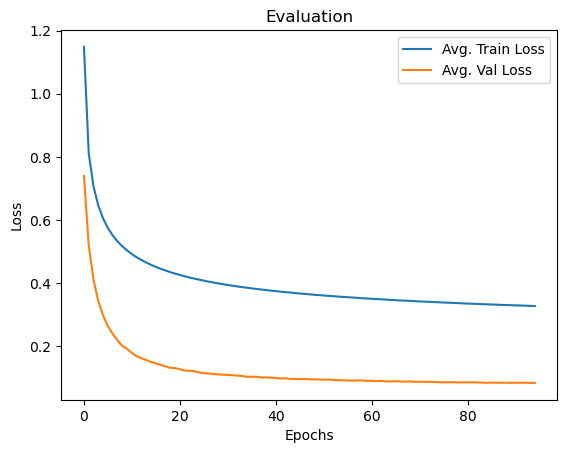

In [11]:
import matplotlib.pyplot as plt

x = [i for i in range(len(loss_epoch))]
plt.plot(x, loss_epoch, label ='Avg. Train Loss')
plt.plot(x, val_loss_epoch, label ='Avg. Val Loss')

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title('Evaluation')
plt.show()

In [12]:
import pickle
with open("loss_result_simple_encoding_epoch_95.pkl", "wb") as f:
    pickle.dump((loss_epoch, val_loss_epoch), f)

In [13]:
model.summary()

Model: "multinomial__model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 positional_embedding (Posit  multiple                 20224     
 ionalEmbedding)                                                 
                                                                 
 sequential_4 (Sequential)   (None, 256, 256)          3158016   
                                                                 
 layer_normalization_12 (Lay  multiple                 512       
 erNormalization)                                                
                                                                 
 dense_60 (Dense)            multiple                  20303     
                                                                 
Total params: 3,199,055
Trainable params: 3,199,055
Non-trainable params: 0
_________________________________________________________________


In [13]:
# model.save_weights('./checkpoints/my_checkpoint_simple_encoding')

In [14]:
# model1 = Multinomial_Model()

In [15]:
# model1.load_weights('./checkpoints/my_checkpoint_simple_encoding')